In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm #this was altered to accomodate new requirements
import seaborn as sns
import networkx as nx
import os, sys
from itertools import product
import math
import statistics
import cmath
'''VMG notes: 
- I have not thought about why link_deletion varies from the notebook version

- Due to version differences, there are now problems with random choice 
(see https://github.com/python/cpython/issues/100805)
because of this, I have changed all instances of random.choice(self.model.nodes) and random.choice(self.nodes)
to random.choice(list(self.model.nodes)) and random.choice(list(self.nodes)), respectively.
There should be a better way, but until the network mechanisms have been finalized, 
I think this will serve as a sufficient patch.

-The progress bar is not functioning, perhaps because of my tqdm import edit.'''


'VMG notes: \n- I have not thought about why link_deletion varies from the notebook version\n\n- Due to version differences, there are now problems with random choice \n(see https://github.com/python/cpython/issues/100805)\nbecause of this, I have changed all instances of random.choice(self.model.nodes) and random.choice(self.nodes)\nto random.choice(list(self.model.nodes)) and random.choice(list(self.nodes)), respectively.\nThere should be a better way, but until the network mechanisms have been finalized, \nI think this will serve as a sufficient patch.\n\n-The progress bar is not functioning, perhaps because of my tqdm import edit.'

In [2]:
#0<gamma_L<gamma_H<1
gamma_L = 0.3
gamma_H = 0.45
fixed_cost = 0.45
sigma = 1.5
beta = 0.95
delta = 0.08
theta = 0.8
xi_g = 16
g = 1

p_ga = random.random()#for global attachment
p_ld = random.random()#for link deletion
p_delta = 0.3#for local attachment


#global function that calculates the weight of the edge, args: the 2 nodes (agent class objects)
#this is the homophily edge weight formula
def Edge_Weight(node1,node2, b, a):
        try:
             weight = 1+math.exp(a*((node1.k-node2.k)-b))
        except OverflowError:
             weight = float('inf')
        return 1/weight  
    
def calculating_k_c(agent, gamma, E_t, time):
        a1 = pow(agent.k,gamma) 
        k = theta*(agent.alpha*a1-agent.consum + (1-delta)*agent.k)
        k_before = agent.alpha*a1-agent.consum + (1-delta)*agent.k
        if(round(k_before,3) == round(agent.critical,3)):
            eta = 1
        elif(round(k_before,3) == round((xi_g*agent.critical)/theta),3):
            eta = 0
        else:
            t1 = xi_g*(agent.critical/theta)
            t2 = t1 - agent.critical
            t3 = 1/t2
            t4 = t3*k_before
            eta = round(1 - t4,2)
        if(eta > 1 or eta <0):
            print("Agent: ", agent.unique_id)
            print("t1 = ", t1)
            print("t2 = ", t2)
            print("t3 = ", t3)
            print('t4 = ', t4)
            print("eta = ", eta)
            print()
            print()
           
        if(k_before > agent.critical and k > agent.critical*xi_g):
            k_new = (eta + (1 - eta)*theta)*k_before
        else:
            k_new = k
              
        slope = gamma*agent.alpha*pow(agent.k, gamma -1) + (1 - delta) - (1/theta)
        a2 = pow(k_new,(gamma-1))
        e1 = pow(beta,time-1)*E_t*theta*(agent.alpha*gamma*a2 + (1-delta))
        e2 = pow(e1, (1/sigma))
        con = agent.consum * e2
        return k_new, k_before, con, slope
    
def isocline(agent):
        if(agent.tec == 'H'):
            con_cond = agent.alpha*pow(agent.k, gamma_H) + (1-delta)*agent.k - agent.k/theta
        if(agent.tec == 'L'):
            con_cond = agent.alpha*pow(agent.k, gamma_L) + (1-delta)*agent.k - agent.k/theta   
        return con_cond   

In [3]:
def find_critical(agent):
    micawbar = pd.read_csv("micawbar.csv")
    if(agent.alpha < (min(micawbar.alpha))):
        critical = max(micawbar.kt) + 0.6

    elif(agent.alpha > max(micawbar.alpha)):
        critical = min(micawbar.kt) - 1

    else:
        ability = micawbar.alpha.to_numpy()
        kt = micawbar.kt.to_numpy()
        for i in range(len(ability)):
            if(agent.alpha == ability[i]):
                critical = kt[i]
            elif(ability[i] < agent.alpha):
                while(ability[i]<agent.alpha):
                    i+=1
                critical = kt[i]
            else:
                while(ability[i] > agent.alpha):
                    i -= 1
                critical = kt[i]
    #print("Agent = {}, Alpha = {} ,Critical = {}".format(agent.unique_id, agent.alpha, critical))
    return critical

In [4]:
class MoneyAgent(Agent):
    
    def __init__(self, unique_id, model):
        
        super().__init__(unique_id, model)
        self.k = (capital[unique_id]) #initial stock of wealth
        self.lamda = round(random.uniform(0.1,1),1) #saving propensity
        while (self.lamda == 1):
            self.lamda = round(random.uniform(0.1,1),1)    
        self.alpha = alpha[unique_id]#human capital 
        self.tec = 'NA'
        self.income = 0 #initialising income
        self.income_generation() #finding income corresponding to the human capital,
                                 #needed here to set the initial consumption
        self.front = 0 #for micawber frontier
        con_cond = isocline(self)
        #self.consum = isocline(self)
        #if(self.consum < 0):
            #self.consum = 0.1
        if(self.tec == 'H'):
            self.slope = gamma_H*self.alpha*pow(self.k, gamma_H -1) + 1 - delta - 1/theta
        else:
            self.slope = gamma_L*self.alpha*pow(self.k, gamma_L -1) + 1 - delta - 1/theta
    
        if(self.slope > 0): #small k_t
            #print("1st quadrant")
            if(con_cond > 0 and con_cond<self.k):
                self.consum = con_cond
            else:
                con = con_cond - random.random()
                while(con>self.k or con < 0):
                    con = con_cond - random.random()
                self.consum = con
        else:
            #print("4th quadrant")
            if(con_cond > 0 and con_cond <self.k):
                self.consum = con_cond
            else:
                con = con_cond + random.random()
                while(con>self.k or con<0):
                    con = con_cond + random.random()
                self.consum = con
        if(self.tec == 'H'):
            a1 = pow(self.k,gamma_H)
        else:
            a1 = pow(self.k,gamma_L)       
        self.k_before = self.alpha*a1-self.consum + (1-delta)*self.k
        self.critical = find_critical(self)
        self.model.agents.append(self)

        
        
    #function that decides income based on the type of technology
    def income_generation(self): 
        #print("Generating income")
        b1 = pow(self.k,gamma_H)
        H = self.alpha*b1 - fixed_cost
        
        b2 = pow(self.k,gamma_L)
        L = self.alpha*b2
        
        self.front = H
        if(H>=L): #
            self.income = H
            self.tec = 'H'
        else:
            self.income = L
            self.tec = 'L'
            
    
    #function that updates the capital and consumption for the next time step    
    def income_updation(self):
        #print("Income updation")
        #finding expected value of income at each time step
        e_t = [a.income for a in self.model.agents] #is this k or f(alpha,k)?
        E_t = statistics.mean(e_t)
        k = self.k
        alpha = self.alpha
        consum = self.consum
        #print("Agent:{}  Tec: {}".format(self.unique_id, self.tec))
        #print("Old k = {}, alpha = {} " .format(k, alpha))
        #print("mean : ", E_t)
       
        if(self.tec == 'H'):
            
            k_new, k_before, con, slope = calculating_k_c(self, gamma_H, E_t, self.model.time)
            self.k = k_new
            
            c_cond = isocline(self)
            #print("c_cond = ", c_cond)
            
            if(slope > 0):
                #print("1st quadrant")
                if(con <=c_cond and con<self.k):
                    self.consum = con
                else:
                    con = c_cond - random.random()
                    while(con>self.k or con < 0):
                        con = c_cond - random.random()
                    self.consum = con
            else:
                #print("4th quadrant")
                if(con > c_cond and con<self.k):
                    self.consum = con
                else:
                    con = c_cond - random.random()
                    while(con>self.k or con < 0):
                        con = c_cond - random.random()
                    self.consum = con

        if(self.tec == 'L'):
            
            k_new, k_before, con, slope = calculating_k_c(self, gamma_L, E_t, self.model.time)
            self.k = k_new
            
            c_cond = isocline(self)
            #print("c_cond = ", c_cond)

            if(slope > 0):
                #print("1st quadrant")
                if(con <=c_cond and con<self.k):
                    self.consum = con
                else:
                    con = c_cond - random.random()
                    while(con>self.k or con < 0):
                        con = c_cond - random.random()
                    self.consum = con
            else:
                #print("4th quadrant")
                if(con > c_cond and con<self.k):
                    self.consum = con
                else:
                    con = c_cond - random.random()
                    while(con>self.k or con<0):
                        con = c_cond - random.random()
                    self.consum = con  
        #print("Old C:", consum)   
        #print("New Consum :", self.consum)
    
    #finding neighbor nodes for the purpose of making an edge/connection
    def neighbors(self):
        neighbors_nodes = list(nx.all_neighbors(self.model.G,self.unique_id))
        neighbors = []
        for node in neighbors_nodes:
            for agent in self.model.agents:
                if(agent.unique_id == node):
                    neighbors.append(agent)
        return neighbors
    
     #function used to trade/communicate     
    def give_money(self): 
        b = self.model.b
        a = self.model.a
        neighbors = self.neighbors()
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            while(other.unique_id == self.unique_id):
                other = self.random.choice(neighbors)  
            w = self.model.G[self.unique_id][other.unique_id]['weight'] 
            if(w >= random.random()): 
                xi = self.income
                xj = other.income
                delta_income = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_income
                xj_new = xj + delta_income
                other.income = xj_new
                self.income = xi_new
                for neighbor in neighbors:
                    self.model.G[self.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(self,neighbor,b, a)
                other_neighbors = other.neighbors()
                for neighbor in other_neighbors:
                    if(neighbor.unique_id != other.unique_id):
                        self.model.G[other.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(other,neighbor,b, a)
        
    def LocalAttachment_v1(self): 
        b = self.model.b
        a = self.model.a
        node1 = random.choice(list(self.model.nodes))
        node2 = random.choice(list(self.model.nodes))
        count = 0 #to avoid an infinite loop when all agents have already made links with each other
        while(self.model.G.has_edge(node1,node2)==True and count <5):
            node2 = random.choice(list(self.model.nodes))
            node1 = random.choice(list(self.model.nodes))
            count +=1
        for agent in self.model.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.model.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, b, a))
        
        
    #1. select nodes i and j, with a probability proportional to the weight (wij) between them.
    #2. j selects a neighbour with a probability proportional to the weight between them such that there is no edge between 
    #i and k. 
    #3. a link is made between i and k with edge weight w0 (here, w0 = 1) and all edge weights are increased by wr(wr-calculated 
    #new edge weight between i and j)
    def LocalAttachment_v2(self):
        b = self.model.b
        a = self.model.a
        #print("LA done")
        links_nodes = list(self.model.G.edges(data= 'weight'))
        #print('Link nodes=', links_nodes)
        edge_weight_sum = sum(k for i, j,k in links_nodes)
        #print('Weight sum = ', edge_weight_sum)
        edge_weights = []
        for edge in links_nodes:
            edge_weights.append(edge[2])
        #print('Edge weights = ', edge_weights)
        edge_prob = []
        for edge_w in edge_weights:
            edge_prob.append(edge_w/edge_weight_sum)
        #print('Edge prob = ', edge_prob)
        arr_pos = [i for i in range(len(links_nodes))]
        pos = np.random.choice(arr_pos, p = edge_prob)
        chosen = links_nodes[pos]
        #print("Chosen nodes:", chosen[0:2])
        node1 = chosen[0]
        node2 = chosen[1]
        node1_a = next((agent for agent in self.model.agents if agent.unique_id == node1), None)
        node2_a = next((agent for agent in self.model.agents if agent.unique_id == node2), None)
        #print("Keeping node1 as:", node1)
        #print("Keeping node2 as:", node2)
        #finding neighbors of node2
        neighbors = [n for n in self.model.G.neighbors(node2)]
        #print("Neighbors of {} are:{}".format(node2,neighbors))
        if(len(neighbors)>1):
            #print("Finding 3rd node")
            links_nodes = list(self.model.G.edges(node2, data= 'weight'))
            #print('Link nodes=', links_nodes)
            edge_weight_sum = sum(k for i, j,k in links_nodes)
            #print('Weight sum = ', edge_weight_sum)
            edge_weights = []
            for edge in links_nodes:
                edge_weights.append(edge[2])
            #print('Edge weights = ', edge_weights)
            edge_prob = []
            for edge_w in edge_weights:
                edge_prob.append(edge_w/edge_weight_sum)
            #print('Edge prob = ', edge_prob)
            arr_pos = [i for i in range(len(links_nodes))]
            pos = np.random.choice(arr_pos, p = edge_prob)
            chosen = links_nodes[pos]
            #print("Chosen nodes:", chosen[0:2])
            for node in chosen[0:2]: #because the 3rd element is weight
                if(node!= node2):
                    node3 = node
                    #print('3rd node = ', node3)
                    if(self.model.G.has_edge(node1,node3)==False and random.random()>p_delta):
                        node3_a = next((agent for agent in self.model.agents if agent.unique_id == node3), None)
                        self.model.G.add_edge(node1,node3,weight = Edge_Weight(node1_a,node3_a, b, a))
                    
    
   #links are deleted randomly at every time step
    def Link_Deletion(self):
        #print('Deletion')
        if(random.random()>p_ld):
            node1 = random.choice(list(self.model.nodes))
            node2 = random.choice(list(self.model.nodes))
            count = 0
            while(self.model.G.has_edge(node1,node2)==False and count<5):
                node2 = random.choice(list(self.model.nodes))
                count +=1
            if(count !=5):
                self.model.G.remove_edge(node1,node2)
        #print('deletion done')
                    
    def step(self):
        #if(self.k > 0):
        self.income_updation()
        self.give_money()
        #self.LocalAttachment_v1()
        self.LocalAttachment_v2()
        self.Link_Deletion()
        self.income_generation() 

In [5]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,b, a,N=500): #N- number of agents

        self.N = N
        self.b =b
        self.a = a
        self.agents = []
        self.gini = 0
        self.time = 0
        self.count_GA = 0
        self.G = nx.barabasi_albert_graph(n=N, m = 1)
        nx.set_edge_attributes(self.G, 1, 'weight') #setting all initial edges with a weight of 1
        self.nodes = np.linspace(0,N-1,N, dtype = 'int') #to keep track of the N nodes   
        
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {"Gini": 'gini'},agent_reporters={"k_t":'k','income':'income',
                                           'H':'front', 'consumption':'consum','lamda':'lamda','alpha':'alpha', 'technology':'tec',       
                           "slope": "slope","k_t":'k','k_before': 'k_before','critical_k':'critical' })   
        for i, node in enumerate(self.G.nodes()):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)
           
        self.running = True
        self.datacollector.collect(self)
        
    def Global_Attachment(self):
        if(random.random()>p_ga):
            #print("Global Attachment no: {}".format(self.count))
            self.count_GA+=1
            node1 = random.choice(list(self.nodes))
            node2 = random.choice(list(self.nodes))
            while(self.G.has_edge(node1,node2)==True):
                node2 = random.choice(list(self.nodes))
                node1 = random.choice(list(self.nodes))
            #adding the edge node1-node2
            #first: find the class object corresponding to the node
            for agent in self.agents:
                if(agent.unique_id == node1):
                    node1_a = agent
                if(agent.unique_id == node2):
                    node2_a = agent
            #a and b are pre-determined, a is the homophily parameter and b is the characteristic distance
            self.G.add_edge(node1,node2,weight =  Edge_Weight(node1_a,node2_a, self.b, self.a))
        
    def compute_gini(self):
        agent_wealths = [agent.k for agent in self.schedule.agents]
        x = sorted(agent_wealths)
        B = sum(xi * (self.N - i) for i, xi in enumerate(x)) / (self.N * sum(x))
        return 1 + (1 / self.N) - 2 * B
    
    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            #print("Step:", i+1)
            self.time = i+1
            self.step()
            self.Global_Attachment()
            self.gini = self.compute_gini()
            if(self.time != Tg):
                #print("Step: ",self.time)
                data = self.datacollector.get_agent_vars_dataframe()
                data = data.reset_index()        
                #t = (i, i-1)
                #data = data[data['Step'].isin(t)]
                data = data.loc[data.Step==i]
                self.Budget = 0.07*sum(data.loc[data.Step==i,'k_t'])#0.025*sum(data.income) #isn't this the budget? (at time step=1)
                #print(self.Budget)
                B = self.Budget
                agents = data.AgentID.to_numpy()
                eligible = {'agent':[], 'psn':[]}
                for agent in agents:
                    now = data.loc[data.AgentID==agent, 'k_t'].values[0]
                    before = data.loc[data.AgentID == agent, 'k_before'].values[0]
                    critical = data.loc[data.AgentID == agent, 'critical_k'].values[0]
                    if(before> critical and now < critical): 
                        eligible['psn'].append(critical-now)
                        eligible['agent'].append(agent)
                PSN = sum(eligible['psn'])
                if(self.Budget > PSN):
                    for n in range(len(eligible['agent'])):
                        for agent in self.agents:
                            if(eligible['agent'][n]==agent.unique_id):
                                if(self.Budget - eligible['psn'][n]>=0):
                                    agent.k = agent.critical
                                    if(agent.tec == 'H'):
                                        agent.income = agent.alpha*pow(agent.k,gamma_H) - fixed_cost
                                    else:
                                        agent.income = agent.alpha*pow(agent.k, gamma_L)
                                    self.Budget-=eligible['psn'][n]

                    #if there is remaining money
                    if(self.Budget>0):
                        #print("in, remaining budget")
                        temp = data.loc[data['k_t']<data['critical_k']]
                        agents = temp.AgentID.to_numpy()
                        CN = sum(temp['critical_k'] - temp['k_t'])
                        if(CN < B - PSN): #means every intermediate agent can be given money
                            for node in agents:
                                for agent in self.agents:
                                    if(node==agent.unique_id):
                                        critical = temp.loc[temp.AgentID==node, 'critical_k'].values[0]
                                        now = temp.loc[temp.AgentID == node, 'k_t'].values[0]
                                        cn = critical - now
                                        if(self.Budget - cn >=0):
                                            agent.k += cn
                                            if(agent.tec == 'H'):
                                                agent.income = agent.alpha*pow(agent.k,gamma_H) - fixed_cost
                                            else:
                                                agent.income = agent.alpha*pow(agent.k, gamma_L)
                                            self.Budget -= cn

                        else: #means some of them who are closer to threshold can be given money
                            col = temp.columns.values.tolist()
                            #final = temp[['critical_k','k_t']].copy(deep=True)
                            final = temp[col].copy(deep = True)
                            final['cn'] = final['critical_k'] - final['k_t']
                            final = final.sort_values(by=['cn'])
                            #print(final)
                            agents = final.AgentID.to_numpy()
                            for node in agents:
                                for agent in self.agents:
                                    if(node == agent.unique_id):
                                        cn = final.loc[final['AgentID']==node, 'cn'].values[0]
                                        if(self.Budget - cn >= 0):
                                            agent.k +=cn
                                            if(agent.tec == 'H'):
                                                agent.income = agent.alpha*pow(agent.k,gamma_H) - fixed_cost
                                            else:
                                                agent.income = agent.alpha*pow(agent.k, gamma_L)
                                            self.Budget-=cn     

                        if(B > PSN + CN): #even after giving intermediate agent money there is still budget available
                            #in this case need-based assistance to agents who are below kp = 3.4
                            for agent in self.agents:
                                if(agent.k < 3.4):
                                    money_req = 3.4 - agent.k
                                    if(self.Budget-money_req >=0):
                                        agent.k = 3.4
                                        if(agent.tec == 'H'):
                                            agent.income = agent.alpha*pow(agent.k,gamma_H) - fixed_cost
                                        else:
                                            agent.income = agent.alpha*pow(agent.k, gamma_L)
                                        self.Budget-=money_req


                else:#if Budget is not sufficient to support everyone, money given to those who are closer to threshold
                    #bubble sorting because we need to find the agents also
                    #print("out")
                    l = len(eligible['psn'])
                    for i in range(l):
                        for j in range(0, l-i-1):
                            if(eligible['psn'][j] > eligible['psn'][j+1]):
                                eligible['psn'][j], eligible['psn'][j+1] = eligible['psn'][j+1], eligible['psn'][j]
                                eligible['agent'][j], eligible['agent'][j+1] = eligible['agent'][j+1], eligible['agent'][j]

                    for n in range(len(eligible['agent'])):
                        track = 0
                        while(self.Budget!=0 or track == 0):
                            for agent in self.agents:
                                if(eligible['agent'][n]==agent.unique_id):
                                    if(self.Budget - eligible['psn'][n]>=0):
                                        agent.k = agent.critical
                                        if(agent.tec == 'H'):
                                            agent.income = agent.alpha*pow(agent.k,gamma_H) - fixed_cost
                                        else:
                                            agent.income = agent.alpha*pow(agent.k, gamma_L)
                                        self.Budget-=eligible['psn'][n]
                                        track+=1



In [6]:
N = 500
steps = 150
Tg = 20
b = 35
a = 0.69
alpha = np.random.normal(loc = 1.08, scale = 0.074, size = N) 
capital = np.random.uniform(low = 0.1, high = 10, size = N)
yp = 1.62

model = BoltzmannWealthModelNetwork(b, a,N)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)


agent_df.to_csv("Experiment2_V2_{}Agents_{}Steps.csv".format(N,steps))
model_df.to_csv("Experiment2_V2_Model_{}Agents_{}Steps.csv".format(N,steps))

  0%|          | 0/150 [00:00<?, ?it/s]

In [7]:
agent = pd.read_csv("Experiment2_V2_{}Agents_{}Steps.csv".format(N,steps))
agent

,Step,AgentID,k_t,income,H,consumption,lamda,alpha,technology,slope,k_before,critical_k
0,0,0,6.366680,2.280887,0.000000,6.298828e-01,0.9,1.187252,H,-0.136980,7.958350,1.633401
1,0,1,2.227882,1.426047,0.000000,6.908456e-01,0.3,1.121414,L,-0.137973,2.784853,3.138653
2,0,2,8.395954,2.714634,0.000000,3.939687e-01,0.4,1.214764,H,-0.160384,10.494943,0.576922
3,0,3,6.287632,2.161793,0.000000,5.368748e-01,0.4,1.141878,H,-0.143076,7.859540,2.614143
4,0,4,3.323393,1.798031,0.000000,7.013119e-01,0.4,1.254073,L,-0.167693,4.154241,0.432866
...,...,...,...,...,...,...,...,...,...,...,...,...
75495,150,495,10.088307,2.389303,2.389303,7.681688e-138,0.8,1.003445,H,-0.175363,8.771644,10.557019
75496,150,496,9.633071,2.728935,2.728935,6.007210e-06,0.7,1.147064,H,-0.086502,2.048807,2.614143
75497,150,497,9.102011,2.553674,2.553674,9.185763e-06,0.2,1.111837,H,-0.136779,7.049860,3.302464
75498,150,498,8.831992,2.464608,2.464608,4.812547e-05,0.8,1.093588,H,-0.124589,6.120737,4.276761


Text(0, 0.5, 'Density')

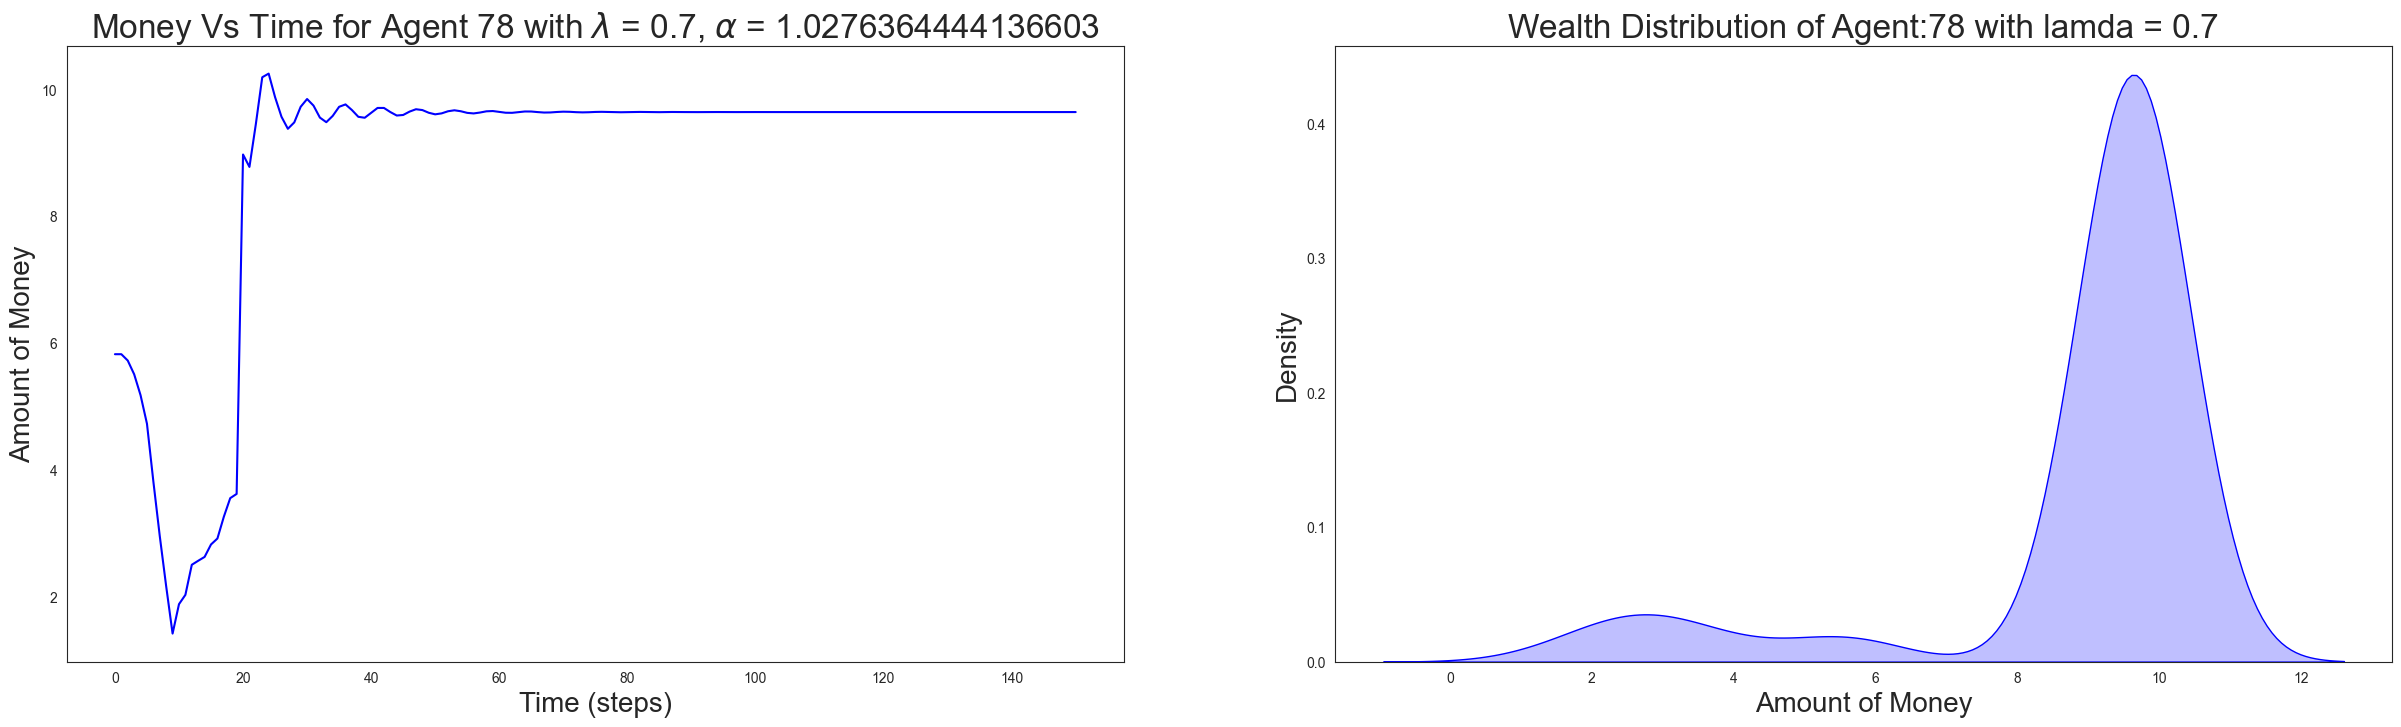

In [8]:
n = random.randint(0,99)
time = (agent.loc[agent['AgentID']==n, 'Step'].reset_index(drop = True)).to_numpy()
money = (agent.loc[agent['AgentID']==n, 'k_t'].reset_index(drop = True)).to_numpy()
lamda = agent.loc[agent['AgentID'] == n, 'lamda'].reset_index(drop = True)[0]
alpha = agent.loc[agent['AgentID'] == n, 'alpha'].reset_index(drop = True)[0]
sns.set_style("white")
fig, ax = plt.subplots(1,2,figsize =(30,8))
ax[0].plot(time,money, color = "blue")
ax[0].set_title("Money Vs Time for Agent {} with $\lambda$ = {}, $\\alpha$ = {}".format(n,lamda,alpha), fontsize = 24)
ax[0].set_xlabel("Time (steps)", fontsize = 20)
ax[0].set_ylabel("Amount of Money", fontsize = 20)

sns.kdeplot(money, fill =True, ax = ax[1], color = 'blue')
ax[1].set_title("Wealth Distribution of Agent:{} with lamda = {}".format(n, lamda), fontsize = 24)
ax[1].set_xlabel("Amount of Money", fontsize = 20)
ax[1].set_ylabel("Density", fontsize = 20)
#plt.savefig("Agent{}.png".format(agent),bbox_inches='tight')

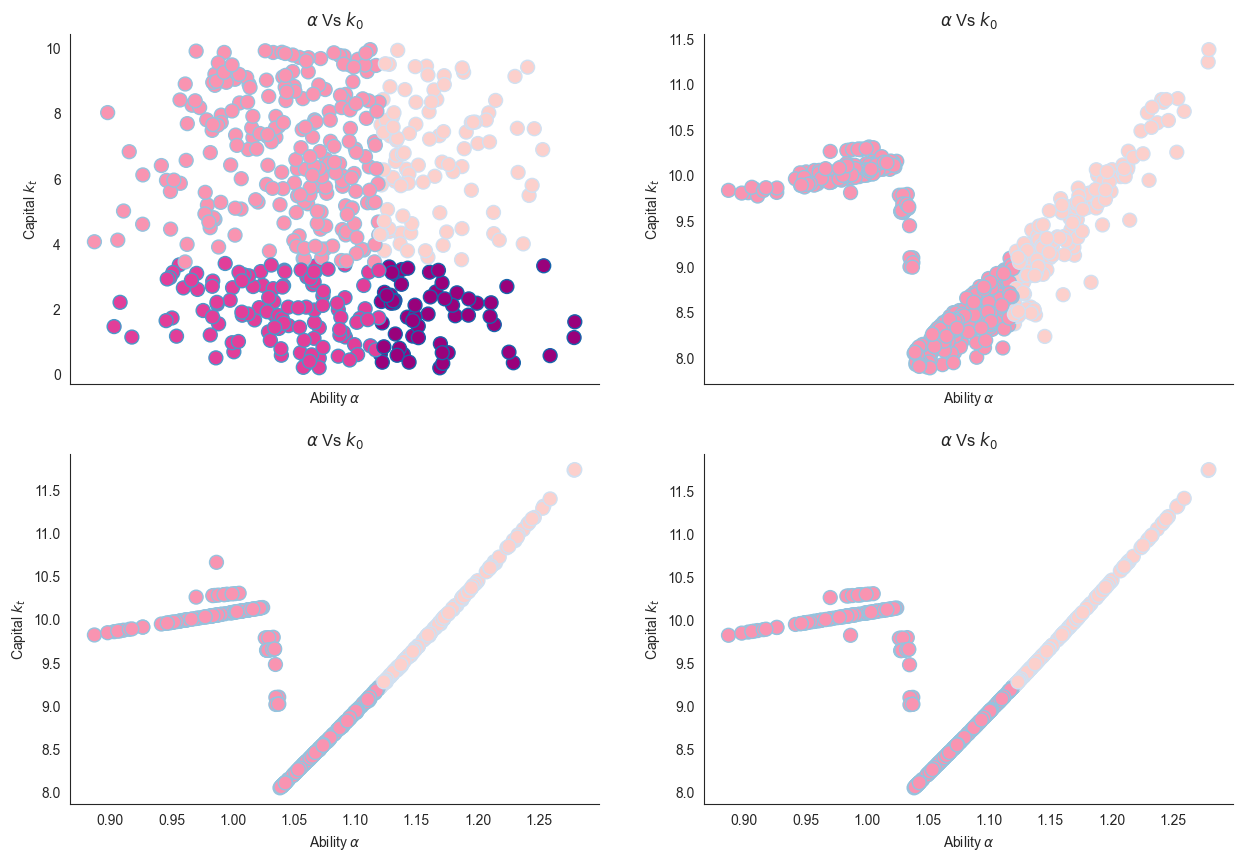

In [9]:
steps = [0,50,100,150]
yp = 3.4
xp = 1.12


fig,ax = plt.subplots(2,2, figsize=(15,10), sharex = True)
palette_f = sns.color_palette("RdPu", 4).as_hex()
palette_e = sns.color_palette("Blues", 4).as_hex()

i = 0
j = 0
for step in steps:
    initial = agent.loc[agent.Step==step]
    y = initial['k_t']
    x = initial['alpha']

    fill_colors = []
    for k,a in zip(list(y),list(x)):
        if (k>= yp and a>=xp):
            fill_colors.append(palette_f[0])#('lightgreen')
        elif(k>=yp and a<xp):
            fill_colors.append(palette_f[1])#('yellow')
        elif(k<yp and a<xp):
            fill_colors.append(palette_f[2])#('slateblue')
        else:
            fill_colors.append(palette_f[3])#('turquoise')

    edge_colors = []               
    for k,a in zip(list(y),list(x)):
        if (k>= yp and a>=xp):
            edge_colors.append(palette_e[0])#('crimson')
        elif(k>=yp and a<xp):
            edge_colors.append(palette_e[1])#('blue')
        elif(k<yp and a<xp):
            edge_colors.append(palette_e[2])#('orange')
        else:
            edge_colors.append(palette_e[3])#('indigo')
    ax[i][j].set_xlabel("Ability $\\alpha$")
    ax[i][j].set_ylabel("Capital $k_t$")
    ax[i][j].set_title("$\\alpha$ Vs $k_0$")
    ax[i][j].scatter(x = initial['alpha'], y = initial['k_t'], s = 100, color=fill_colors, edgecolors=edge_colors)
    ax[i][j].spines['top'].set_visible(False)
    ax[i][j].spines['right'].set_visible(False)
    j+=1
    if(j==2):
        i+=1
        j = 0
#plt.savefig("k0")